# 📓 03_stableford_simulation.ipynb
**Purpose:** Corrected Monte Carlo simulation using Stableford scoring based on per-hole par values.

In [43]:
import pickle
import random
import numpy as np
import sys
from pathlib import Path
import importlib

# Or safer for notebooks where __file__ is not defined:
sys.path.append(str(Path().resolve().parent / "src"))

import golf_utils
import golf_scoring
importlib.reload(golf_scoring)

import golf_utils

from golf_utils import postprocess_players
import golf_scoring
from collections import defaultdict
from golf_classes import Player, PlayerRoundInfo, Tournament, Round, Team
from golf_scoring import compute_real_stableford, simulate_round,  stableford_points, calibrated_simulate_round, hole_pars



In [ ]:
calcutta_data = {
    "players": {},       # str -> Player
    "tournaments": {},   # str -> Tournament
    "mm_teams": {},      # str -> MMTeam (e.g., "Smith/Jones" : MMTeam obj)
    "c_teams": {},       # str -> CTeam (e.g., "Team A" : CTeam obj)
}


players = calcutta_data["players"]
tournaments = calcutta_data["tournaments"]
mm_teams = calcutta_data["mm_teams"]
c_teams = calcutta_data["c_teams"]


In [13]:
def reset_all_data():
    global players, tournaments, teams
    players.clear()
    tournaments.clear()
    teams.clear()
    print("🧹 All data has been reset.")

In [19]:

import pickle

def load_data(path):
    global calcutta_data, players, tournaments, teams
    with open(path, "rb") as f:
        loaded = pickle.load(f)

    calcutta_data["players"] = loaded.get("players", {})
    calcutta_data["tournaments"] = loaded.get("tournaments", {})
    calcutta_data["teams"] = loaded.get("teams", [])

    # Rebind the globals for convenience
    players = calcutta_data["players"]
    tournaments = calcutta_data["tournaments"]
    teams = calcutta_data["teams"]

    print("✅ Data loaded successfully.")


PICKLE_FILE = '../golf_data.pkl'  
load_data(PICKLE_FILE)
print(f"✅ Loaded {len(players)} players and {len(tournaments)} tournaments.")



#postprocess_players(players, calculate_stableford_round)

✅ Data loaded successfully.
✅ Loaded 812 players and 9 tournaments.


In [ ]:

for player in players.values():
    player.compute_stableford_stats(scoring_func=calculate_stableford_round)

In [ ]:
# --- Sample Stableford score for a player ---
def sample_stableford_score(player):
    if not player.rounds:
        return None
    round_info = random.choice(player.rounds)
    return calculate_stableford_round(round_info)

In [ ]:
# --- Simulate team Stableford score ---
def simulate_team_stableford_score(team):
    player_scores = []
    for player in team.members:
        score = sample_stableford_score(player)
        if score is not None:
            player_scores.append(score)

    if len(player_scores) < 4:
        return float('-inf')  # Invalid team

    return sum(sorted(player_scores, reverse=True)[:4])

In [ ]:
# --- Simulate Stableford tournament ---
def simulate_stableford_tournament(teams, num_simulations=10000):
    team_scores = defaultdict(list)

    for _ in range(num_simulations):
        for team in teams:
            score = simulate_team_stableford_score(team)
            team_scores[team.name].append(score)

    team_averages = {name: np.mean(scores) for name, scores in team_scores.items()}
    return team_averages

In [ ]:
# --- Example Team Class and Simulation ---
class Team:
    def __init__(self, name, members):
        self.name = name
        self.members = members

# Random example teams
example_teams = [
    Team("Team A", random.sample(list(players.values()), 6)),
    Team("Team B", random.sample(list(players.values()), 6))
]

# Run simulation
results = simulate_stableford_tournament(example_teams, num_simulations=10000)

# Print results
print("\n🏆 Team Stableford Averages:")
for name, avg in sorted(results.items(), key=lambda x: -x[1]):
    print(f"{name}: {avg:.2f} points")

In [ ]:
from collections import defaultdict, Counter
import random
import numpy as np

def simulate_team_wins(teams, num_simulations=10000, top_n=10, verbose=False):
    """
    Simulate full Stableford-based tournaments and track team wins.

    Args:
        teams: list of Team objects
        num_simulations: number of tournaments to simulate
        top_n: number of top winning teams to return
        verbose: if True, print simulation progress

    Returns:
        List of (team_name, win_count, win_percentage)
    """
    win_counts = Counter()

    for sim in range(num_simulations):
        if verbose and sim % (num_simulations // 10 or 1) == 0:
            print(f"Running simulation {sim + 1}/{num_simulations}...")

        scores = {}
        for team in teams:
            score = simulate_team_stableford_score(team)
            scores[team.name] = score

        max_score = max(scores.values())
        winners = [name for name, score in scores.items() if score == max_score]

        winning_team = random.choice(winners)  # random tie-break
        win_counts[winning_team] += 1

    total = sum(win_counts.values())

    results = [
        (team, count, count / total * 100)
        for team, count in win_counts.most_common(top_n)
    ]

    return results

In [ ]:
def build_random_teams(players, num_teams=30, players_per_team=6, min_rounds=5, verbose=True):
    """
    Build as many random Team objects as possible from players with at least `min_rounds` rounds.
    Will return fewer teams if not enough eligible players are available.

    Args:
        players: dict or list of Player objects
        num_teams: desired number of teams to build
        players_per_team: number of players per team
        min_rounds: minimum number of rounds a player must have to be eligible
        verbose: if True, print how many teams were actually created

    Returns:
        List of Team objects (may be fewer than num_teams)
    """
    player_list = players.values() if isinstance(players, dict) else players

    # Filter eligible players
    eligible_players = [p for p in player_list if len(p.rounds) >= min_rounds]
    total_possible_teams = len(eligible_players) // players_per_team
    teams_to_build = min(num_teams, total_possible_teams)

    if verbose:
        print(f"✅ Building {teams_to_build} team(s) from {len(eligible_players)} eligible players "
              f"(min {min_rounds} rounds each)")

    # Shuffle for randomness
    random.shuffle(eligible_players)

    # Create teams
    teams = []
    for i in range(teams_to_build):
        team_players = eligible_players[i * players_per_team : (i + 1) * players_per_team]
        team = Team(name=f"Team {i + 1}", members=team_players)
        teams.append(team)

    return teams

In [ ]:
def run_random_field_simulation_verbose(
    players,
    num_teams=30,
    players_per_team=6,
    min_rounds=5,
    num_simulations=10000,
    top_n=10,
    verbose=True
):
    """
    Build a random field of teams, simulate tournaments, and print ranked teams with player-level detail.
    """
    # Step 1: Build teams
    teams = build_random_teams(players, num_teams=num_teams,
                                players_per_team=players_per_team,
                                min_rounds=min_rounds,
                                verbose=verbose)

    # Step 2: Simulate team wins
    win_results = simulate_team_wins(teams, num_simulations=num_simulations, top_n=top_n)

    # Step 3: Create lookup for team objects by name
    team_lookup = {team.name: team for team in teams}

    # Step 4: Print results with player Stableford scores
    print(f"\n🏆 Top {top_n} Teams by Win Count (Simulated {num_simulations:,} Tournaments):\n")
    for rank, (team_name, win_count, win_pct) in enumerate(win_results, start=1):
        team = team_lookup[team_name]
        print(f"{rank:>2}. {team_name:<10} | Wins: {win_count:>5} | Win %: {win_pct:>6.2f}%")

        player_scores = []
        for player in team.members:
            score = sample_stableford_score(player)
            player_scores.append((player.name, score))

        # Sort for display (optional: by score descending)
        player_scores.sort(key=lambda x: -x[1] if x[1] is not None else -999)

    for name, score in player_scores:
        # Get the actual Player object by matching name
        player_obj = next(p for p in team.members if p.name == name)
        avg = player_obj.stableford_average
        std = player_obj.stableford_stddev

        score_display = f"{score:.1f}" if score is not None else "N/A"
        avg_display = f"{avg:.2f}"
        std_display = f"{std:.2f}"

        print(f"     - {name:<25} Sampled: {score_display:>6} | Avg: {avg_display:>6} | SD: {std_display:>6}")

In [ ]:
run_random_field_simulation_verbose(players, num_teams=40, players_per_team=6,
                            min_rounds=5, num_simulations=10000, top_n=8)

In [ ]:
sample_player = list(players.values())[0]
print(sample_player.name)
print(sample_player.stableford_scores)
print(sample_player.stableford_average)
print(sample_player.stableford_stddev)

In [ ]:
# Run 5000 simulations and get top 8 teams by win count
results = simulate_team_wins(example_teams, num_simulations=5000, top_n=8)

# Print nicely
print(f"\n🏆 Top Teams by Simulated Wins:\n")
print(f"{'Rank':<5} {'Team Name':<20} {'Wins':>8} {'Win %':>8}")
print("-" * 40)
for i, (name, wins, pct) in enumerate(results, 1):
    print(f"{i:<5} {name:<20} {wins:>8} {pct:>7.2f}")

In [1]:


# --- Calculate and Print Player Stableford Averages ---

def calculate_and_print_player_stableford_stats(players, top_n=20, min_rounds=5):
    """
    Calculate and print top players based on average Stableford score across their rounds.
    
    Args:
        players: dict or list of Player objects
        top_n: number of top players to display
        min_rounds: minimum number of rounds a player must have to be considered
    """
    player_stats = []

    player_list = players.values() if isinstance(players, dict) else players

    for player in player_list:
        stableford_scores = []
        for rnd in player.rounds:
            score = compute_real_stableford(rnd)
            if score is not None:
                stableford_scores.append(score)

        if len(stableford_scores) >= min_rounds:
            avg_stableford = np.mean(stableford_scores)
            std_stableford = np.std(stableford_scores)
            num_rounds = len(stableford_scores)
            player_stats.append((player.name, avg_stableford, std_stableford, num_rounds))
    
    # Sort by highest average Stableford (higher is better in Stableford!)
    player_stats.sort(key=lambda x: -x[1])

    # --- Print ---
    header = "{:<5} {:<25} {:>15} {:>12} {:>10}".format("Rank", "Player Name", "Avg Stableford", "Std Dev", "Rounds")
    print(f"\n🏌️ Top {top_n} Players by Average Stableford Score (Minimum {min_rounds} Rounds):\n")
    print(header)
    print("-" * len(header))

    for idx, (name, avg_score, std_dev, num_rounds) in enumerate(player_stats[:top_n], start=1):
        row = "{:<5} {:<25} {:>15.2f} {:>12.2f} {:>10}".format(idx, name, avg_score, std_dev, num_rounds)
        print(row)  

In [ ]:

calculate_and_print_player_stableford_stats(players, top_n=35, min_rounds=5)

In [ ]:
# --- Inspect a Player's Rounds: Perfectly Aligned Horizontal View ---

def inspect_player_stableford_rounds(players, player_name):
    """
    Print hole-by-hole gross, net, and Stableford points for each round of a player, horizontally aligned.
    """
    player = players.get(player_name) if isinstance(players, dict) else None
    if not player:
        print(f"Player '{player_name}' not found.")
        return
    
    print(f"\n=== Rounds for {player.name} ===\n")
    
    for rnd_idx, rnd in enumerate(player.rounds):
        print(f"--- Round {rnd_idx + 1}: Tournament={rnd.tournament_name}, Round={rnd.round_number}, Handicap={rnd.handicap} ---")
        
        strokes = strokes_received_per_hole(rnd.handicap)
        gross_scores = rnd.hole_scores

        gross_list = []
        net_list = []
        stableford_list = []

        gross_total = 0
        net_total = 0
        stableford_total = 0

        # Hole numbers
        hole_numbers = [f"{i+1:>3}" for i in range(18)]  # right-align hole numbers 1-18

        for i in range(18):
            try:
                gross = float(gross_scores[i])
            except (ValueError, TypeError, IndexError):
                gross = None
            
            if gross is None:
                net = None
                stableford = None
            else:
                net = gross - strokes[i]
                net_relative_to_par = round(net - hole_pars[i])
                stableford = stableford_points(net_relative_to_par)
            
            gross_list.append(f"{int(gross):>3}" if gross is not None else "  X")
            net_list.append(f"{int(net):>3}" if net is not None else "  X")
            stableford_list.append(f"{int(stableford):>3}" if stableford is not None else "  X")

            if gross is not None:
                gross_total += gross
            if net is not None:
                net_total += net
            if stableford is not None:
                stableford_total += stableford

        # Add totals
        hole_numbers.append('Tot')
        gross_list.append(f"{int(gross_total):>3}")
        net_list.append(f"{int(net_total):>3}")
        stableford_list.append(f"{int(stableford_total):>3}")

        # --- Print nicely aligned ---
        print("Hole:      " + " ".join(hole_numbers))
        print("Gross:     " + " ".join(gross_list))
        print("Net:       " + " ".join(net_list))
        print("Stableford:" + " ".join(stableford_list))
        print("\n")

In [ ]:


#inspect_player_stableford_rounds(players, "Chris Taylor")

inspect_player_stableford_rounds(players, "Justin Madison")




In [ ]:
# --- Find and Print Outlier Stableford Rounds ---

def find_stableford_outlier_rounds(players, max_stableford=45):
    """
    Scan all players and print rounds where total Stableford points exceed max_stableford.
    
    Args:
        players: dict or list of Player objects
        max_stableford: maximum reasonable Stableford score to allow
    """
    player_list = players.values() if isinstance(players, dict) else players
    outliers = []

    for player in player_list:
        for rnd in player.rounds:
            score = calculate_stableford_round(rnd)
            if score is not None and score > max_stableford:
                outliers.append((player.name, rnd.tournament_name, rnd.round_number, score))

    if not outliers:
        print(f"✅ No rounds exceeded {max_stableford} Stableford points.")
        return

    print(f"\n🚨 Found {len(outliers)} outlier rounds exceeding {max_stableford} Stableford points:\n")
    print(f"{'Player Name':<25} {'Tournament':<30} {'Round':<6} {'Stableford Points':>8}")
    print("-" * 75)

    for name, tournament, round_num, score in outliers:
        print(f"{name:<25} {tournament:<30} {round_num:<6} {score:>8.1f}")

# --- Example Usage ---

find_stableford_outlier_rounds(players, max_stableford=45)

In [21]:
rounds_with_holes = [
    rnd for player in players.values()
    for rnd in player.rounds
    if rnd.hole_scores and len(rnd.hole_scores) == 18
]



In [23]:
def audit_round_data(players):
    total_rounds = 0
    rounds_with_holes = 0
    rounds_without_holes = 0

    for player in players.values():
        for rnd in player.rounds:
            total_rounds += 1
            if rnd.hole_scores and len(rnd.hole_scores) == 18:
                rounds_with_holes += 1
            else:
                rounds_without_holes += 1

    print(f"Total player rounds: {total_rounds}")
    print(f"Rounds with hole-by-hole data: {rounds_with_holes} ({rounds_with_holes / total_rounds:.1%})")
    print(f"Rounds with only gross/net: {rounds_without_holes} ({rounds_without_holes / total_rounds:.1%})")

    return {
        'total_rounds': total_rounds,
        'rounds_with_holes': rounds_with_holes,
        'rounds_without_holes': rounds_without_holes
    }



In [24]:
audit_results = audit_round_data(players)

Total player rounds: 28421
Rounds with hole-by-hole data: 4970 (17.5%)
Rounds with only gross/net: 23451 (82.5%)


       real_stableford  simulated_stableford        error
count      4970.000000           4970.000000  4970.000000
mean         19.430584             16.187726    -3.242857
std          11.818481              6.604118    13.569747
min         -24.000000            -31.000000   -62.000000
25%          13.000000             12.000000    -9.000000
50%          18.000000             16.000000    -2.000000
75%          23.000000             21.000000     5.000000
max          70.000000             42.000000    45.000000


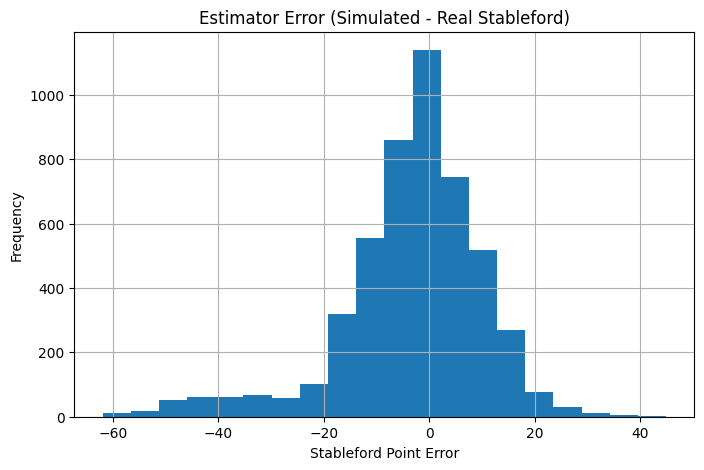

In [45]:
# golf_scoring 2.0


import pandas as pd
import matplotlib.pyplot as plt

def simulate_stableford_for_round(rnd):
    return simulate_round(rnd.handicap)

def simulate_stableford_for_round_calibrated(rnd):
    return simulate_round(rnd.handicap)


def error_analysis(players):
    rounds_with_holes = [
        rnd for player in players.values()
        for rnd in player.rounds
        if rnd.hole_scores and len(rnd.hole_scores) == 18
    ]

    comparison = []
    for rnd in rounds_with_holes:
        real = compute_real_stableford(rnd)
        #simulated = simulate_stableford_for_round(rnd)
        simulated = simulate_stableford_for_round_calibrated(rnd)
        comparison.append({
            'player': rnd.player,
            'tournament': rnd.tournament_name,
            'real_stableford': real,
            'simulated_stableford': simulated,
            'gross': rnd.total,
            'net': rnd.net,
            'handicap': rnd.handicap,
            'error': simulated - real
        })

    df = pd.DataFrame(comparison)

    print(df[['real_stableford', 'simulated_stableford', 'error']].describe())

    # Error histogram
    plt.figure(figsize=(8, 5))
    df['error'].hist(bins=20)
    plt.title("Estimator Error (Simulated - Real Stableford)")
    plt.xlabel("Stableford Point Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    return df

# Run the analysis
df_error = error_analysis(players)



In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def heatmap_error_by_handicap(df_error):
    """
    Creates 3 heatmaps:
    - Mean estimator error by handicap band.
    - Std deviation of error by handicap band.
    - Count of rounds by handicap band.
    """

    # Bin handicaps into bands (e.g., 0-4, 5-9, ...)
    bins = list(range(0, 41, 5)) + [99]
    labels = [f'{b}-{b+4}' if b < 40 else '40+' for b in range(0, 41, 5)]
    df_error['handicap_band'] = pd.cut(df_error['handicap'], bins=bins, labels=labels, right=False)

    # Create pivot tables
    pivot_mean = df_error.pivot_table(index='handicap_band', values='error', aggfunc='mean')
    pivot_std = df_error.pivot_table(index='handicap_band', values='error', aggfunc='std')
    pivot_count = df_error.pivot_table(index='handicap_band', values='error', aggfunc='count')

    # Plot mean error
    plt.figure(figsize=(8, 4))
    sns.heatmap(pivot_mean.T, annot=True, fmt=".1f", cmap="RdBu_r", center=0)
    plt.title("Mean Estimator Error by Handicap Band (Simulated - Real)")
    plt.xlabel("Handicap Band")
    plt.ylabel("Mean Error")
    plt.show()

    # Plot std deviation of error
    plt.figure(figsize=(8, 4))
    sns.heatmap(pivot_std.T, annot=True, fmt=".1f", cmap="YlGnBu")
    plt.title("Estimator Error Std Dev by Handicap Band")
    plt.xlabel("Handicap Band")
    plt.ylabel("Std Dev of Error")
    plt.show()

    # Plot count of rounds
    plt.figure(figsize=(8, 4))
    sns.heatmap(pivot_count.T, annot=True, fmt=".0f", cmap="Greens")
    plt.title("Rounds Count by Handicap Band")
    plt.xlabel("Handicap Band")
    plt.ylabel("Number of Rounds")
    plt.show()

    return {
        'mean_error': pivot_mean,
        'std_error': pivot_std,
        'count': pivot_count
    }


/var/folders/m8/5xrq9ybx4b5dvz9bgn0sk0lc0000gn/T/ipykernel_96212/3252623606.py:19: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_mean = df_error.pivot_table(index='handicap_band', values='error', aggfunc='mean')
/var/folders/m8/5xrq9ybx4b5dvz9bgn0sk0lc0000gn/T/ipykernel_96212/3252623606.py:20: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_std = df_error.pivot_table(index='handicap_band', values='error', aggfunc='std')
/var/folders/m8/5xrq9ybx4b5dvz9bgn0sk0lc0000gn/T/ipykernel_96212/3252623606.py:21: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to 

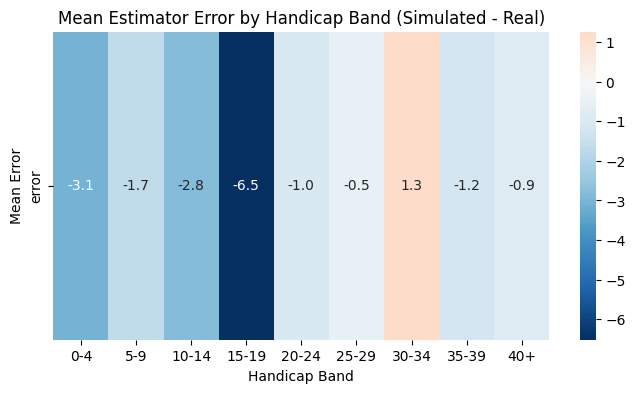

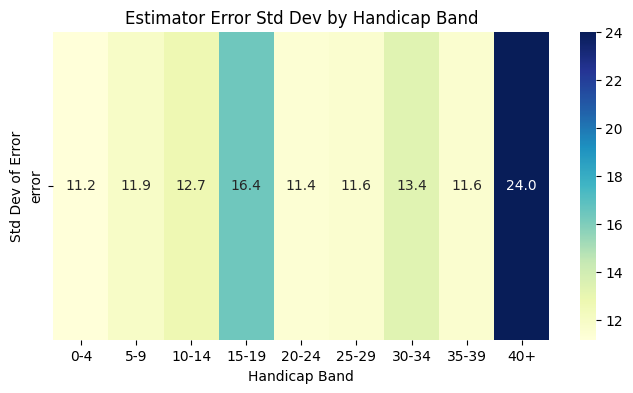

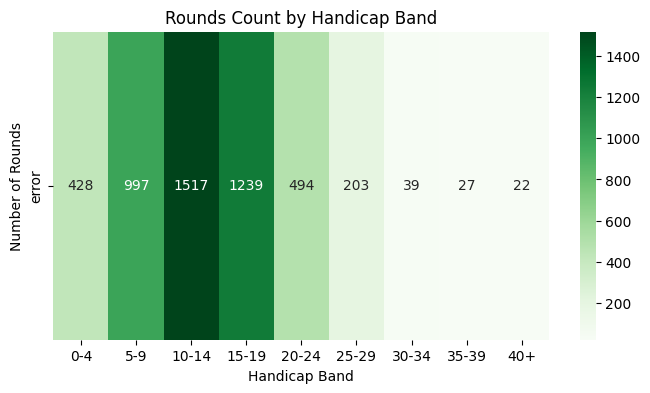

{'mean_error':                   error
 handicap_band          
 0-4           -3.114486
 5-9           -1.651956
 10-14         -2.814107
 15-19         -6.514124
 20-24         -1.048583
 25-29         -0.527094
 30-34          1.256410
 35-39         -1.185185
 40+           -0.863636,
 'std_error':                    error
 handicap_band           
 0-4            11.182266
 5-9            11.915374
 10-14          12.707839
 15-19          16.424535
 20-24          11.447281
 25-29          11.605436
 30-34          13.358849
 35-39          11.615762
 40+            24.000586,
 'count':                error
 handicap_band       
 0-4              428
 5-9              997
 10-14           1517
 15-19           1239
 20-24            494
 25-29            203
 30-34             39
 35-39             27
 40+               22}

In [48]:
heatmap_error_by_handicap(df_error)

